In [26]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.spatial import KDTree

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from tools.log_progress import log_progress

coords_path = os.path.join(data_dir,'analysis','external','antbounds','shelves2.mat')
int_dir = os.path.join(data_dir,'analysis','interim')
pro_dir = os.path.join(data_dir,'analysis','processed')
fig_dir = os.path.join(os.pardir,os.pardir,'reports','figures')
grid_path = os.path.join(data_dir,'preprocessing','processed','waom2_grd.nc')
temp_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
zeta_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_zeta_avg.nc')
pd.options.display.float_format = '{:,.2f}'.format

In [25]:
from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:52700 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [12]:
grd = xr.open_dataset(grid_path)

temp = xr.open_dataset(temp_path).squeeze()
zeta = xr.open_dataset(zeta_path).squeeze()

In [15]:
temp

<xarray.Dataset>
Dimensions:     (eta_rho: 2650, s_rho: 31, xi_rho: 3150)
Coordinates:
    ocean_time  datetime64[ns] 2014-11-07T12:00:00
  * s_rho       (s_rho) float64 -0.9839 -0.9516 -0.9194 -0.8871 -0.8548 ...
    x_rho       (eta_rho, xi_rho) float64 ...
    y_rho       (eta_rho, xi_rho) float64 ...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    Cs_r        (s_rho) float64 ...
    h           (eta_rho, xi_rho) float64 ...
    hc          float64 ...
    temp        (s_rho, eta_rho, xi_rho) float32 ...
    zeta        (eta_rho, xi_rho) float32 ...
Attributes:
    file:                      ocean_avg_0538.nc
    format:                    netCDF-3 64bit offset file
    Conventions:               CF-1.4
    type:                      ROMS/TOMS nonlinear model averages file
    title:                     Whole Antarctic and Ocean Application, 2 km re...
    rst_file:                  ocean_rst.nc
    his_base:                  ocean_his
    avg_base:              

In [8]:
mask_sector = {}
mask_vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)
mask_sector['Total Antarctica'] = xr.DataArray(np.ones_like(grd.lon_rho,dtype=bool),dims=('eta_rho','xi_rho'))
mask_sector['Western East Antarctica'] = (grd.lon_rho>=-10.0) & (grd.lon_rho<60)
mask_sector['Amery/Prydz Bay'] = (grd.lon_rho>=60.0) & (grd.lon_rho<80.0)
mask_sector['Sabrina Coast/Aurora subglacial basin'] = (grd.lon_rho>=80.0) & (grd.lon_rho<130.0) & ~(mask_vostock)
mask_sector['George V Coast/Wilkes subglacial basin'] = ((grd.lon_rho>=130.0) & (grd.lon_rho<155.0)) | ((grd.lon_rho>=155.0) & (grd.lon_rho<170.0) & (grd.lat_rho>=-72))
mask_sector['Ross Sea'] = (grd.lon_rho>=155.0) & ~mask_sector['George V Coast/Wilkes subglacial basin'] |(grd.lon_rho<-140.0)|((grd.lon_rho>=-140.0) & (grd.lon_rho<-120.0) &(grd.lat_rho<-77.0)) 
mask_sector['Amundsen Sea'] = ((grd.lon_rho>=-140.0) & (grd.lon_rho<-120.0) & (grd.lat_rho>=-77.0)) |((grd.lon_rho>=-120.0) & (grd.lon_rho<-90.0))
mask_sector['Bellingshausen Sea'] = (grd.lon_rho>=-90.0) & (grd.lon_rho<-66.0) & (grd.lat_rho>=-75.0)
mask_sector['Weddell Sea'] = (grd.lon_rho > -90) & (grd.lon_rho < -10) & ~ mask_sector['Bellingshausen Sea']

In [23]:
mask_shelf = (grd.h < 1000)
mask_shelf_sector = {}
for key,item in mask_sector.items():
    mask_shelf_sector[key] = item & mask_shelf
mask_shelf_sector['Amundsen Sea'] &= grd.lat_rho < -70 
mask_shelf_sector['Ross Sea'] &= grd.lat_rho < -70
mask_shelf_sector['George V Coast/Wilkes subglacial basin'] &= ~((grd.lon_rho > 160) & (grd.lat_rho > -68.5)) 
mask_shelf_sector['Sabrina Coast/Aurora subglacial basin'] &= grd.lat_rho <= -64
mask_shelf_sector['Western East Antarctica'] &= grd.lat_rho < -64
mask_shelf_sector['Weddell Sea'] &= ~((grd.lat_rho > -63) & (grd.lon_rho > -48))

mask_shelf_sector['Total Antarctica'] = mask_shelf_sector['Amundsen Sea'].copy()
for key,item in mask_shelf_sector.items():
    mask_shelf_sector['Total Antarctica'] |= item

## equip roms grid with depths and volumes

In [18]:
from tools.cartesian_grid_3d import cartesian_grid_3d

lon_u = grd.lon_u.values
lat_u = grd.lat_u.values
lon_v = grd.lon_v.values
lat_v = grd.lat_v.values
h = grd.h.values
zice = grd.zice.values
theta_s = 7#zeta.theta_s.values
theta_b = 8#zeta.theta_b.values
hc = temp.hc.values
N = temp.s_rho.size

zeta = zeta.zeta.values

dx,dy,dz,z = cartesian_grid_3d(lon_u, lat_u, lon_v, lat_v, h, zice, theta_s, theta_b, hc, N, zeta)

grd['dx'] = xr.DataArray(dx,dims=['s_rho','eta_rho','xi_rho'])
grd['dx'] = grd.dx.where(grd.mask_rho == 1)

grd['dy'] = xr.DataArray(dy,dims=['s_rho','eta_rho','xi_rho'])
grd['dy'] = grd.dy.where(grd.mask_rho == 1)

grd['dz'] = xr.DataArray(dz,dims=['s_rho','eta_rho','xi_rho'])
grd['dz'] = grd.dz.where(grd.mask_rho == 1)

grd['z'] = xr.DataArray(z,dims=['s_rho','eta_rho','xi_rho'])
grd['z'] = grd.z.where(grd.mask_rho == 1)

dV = grd.dx * grd.dy * grd.dz
grd['dV'] = dV

In [ ]:
mask_shallow = grd.z>=-200
mask_cavity = grd.zice < 0.0

In [28]:
mask = []
dV = []
weights = []
avg_temp = []

In [27]:
avg_temp = {}

for sec_name,sec_mask in log_progress(mask_shelf_sector.items()):
    
    for depth_name,depth_mask in zip(['shallow','deep','cavity'],[grd.z >= -200, grd.z < -200, grd.zice < 0.0]): 
    
        mask = sec_mask & depth_mask
    
        dV = grd.dV.where(mask)
        weights = dV/dV.sum()
    
        avg_temp[sec_name][depth_name] = (temp.where(mask)*weights).sum().values*1.0

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:55588 remote=tcp://127.0.0.1:52700>
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [22]:
temp_sec = {}

mask = (grd.z >= -200) & mask_shelf_sector['Sabrina Coast/Aurora subglacial basin']

dV = grd.dV.where(mask)
weights = dV/dV.sum()

temp_sec['SB shallow']=(temp.where(mask)*weights).sum().values


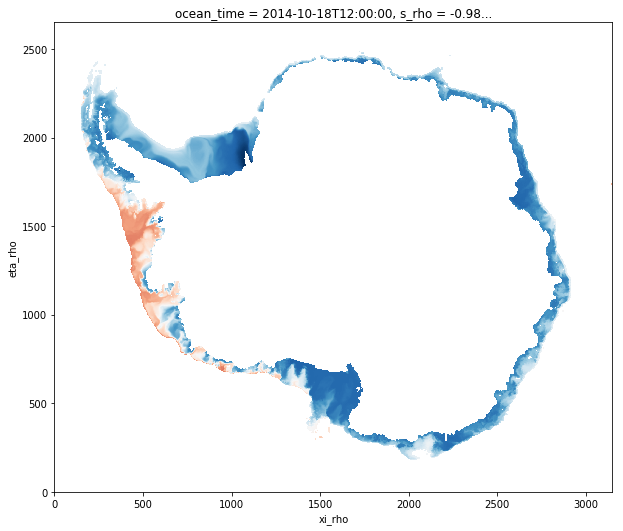

In [62]:
%matplotlib inline
mask = mask_shelf_sector['Total Antarctica']
plt.close()
fig,ax = plt.subplots(figsize=(10,10))
avg.temp.where(mask).plot(add_colorbar=False,ax=ax)
#cs = grd.lat_rho.plot.contour(levels=25,ax=ax,colors='k',alpha=0.5)
#cs2 = grd.lon_rho.plot.contour(levels=50,ax=ax,colors='k',alpha=0.5)
#ax.clabel(cs,inline=1)
#ax.clabel(cs2,inline=1)
ax.set_aspect('equal')
plt.show()